# Analyzing Liquidity Provider Profitability in Uniswap V3
## USDC-WETH 5-basis-points pool

In [1]:
import requests
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # helps with plotting multiple figures
from matplotlib.dates import DateFormatter
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
def run_query(query):

    # endpoint where you are making the request
    request = requests.post('https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'
                            '',
                            json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed. return code is {}.      {}'.format(request.status_code, query))

#### Analysis time-span: April 1, 2024 - April 25, 2024

In [3]:
start_date=int(dt.datetime(2024,4,1).timestamp()) 
end_date=int(dt.datetime(2024,4,25).timestamp()) 
print(start_date,end_date)

1711944000 1714017600


In [4]:
max_timestamp = start_date
data_table = pd.DataFrame()
while max_timestamp<end_date:
    query="""{
            swaps(orderBy: timestamp, orderDirection: asc, first: 1000, skip: 0, where:
            { pool: "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", timestamp_gt: %s}
            ) {
                  timestamp
                  transaction {
                      id
                  }
                  pool {
                        feeTier
                        token0 {
                        id
                        symbol
                        decimals
                               }
                        token1 {
                        id
                        symbol
                        decimals
                               }
                      }
                  sender
                  recipient
                  origin
                  amount0
                  amount1
                  amountUSD
                  sqrtPriceX96
                  logIndex
             }
            }"""%(max_timestamp)
    temp=run_query(query)
    temp_table=pd.json_normalize(temp['data']['swaps'])
    data_table=pd.concat([data_table,temp_table],ignore_index=True)
    max_timestamp=data_table['timestamp'].apply(int).max() # updates max_timestamp
    
data_table['datetime']=data_table['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(int(x)))
data_table=data_table[data_table['timestamp'].apply(lambda x: int(x))<=end_date]

In [5]:
data_table_1 = data_table.copy()
data_table_1

,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,logIndex,transaction.id,pool.feeTier,pool.token0.id,pool.token0.symbol,pool.token0.decimals,pool.token1.id,pool.token1.symbol,pool.token1.decimals,datetime
0,1711944047,0xf3de3c0d654fda23dad170f0f320a92172509127,0xf3de3c0d654fda23dad170f0f320a92172509127,0xbc68c8911820929d49b48801648869cc8e126db1,-297.533202,0.082416049419348,297.6480888881939963967815171800571,1318284768739944146086333688645666,117,0xe6c3afee9365ea795c7b207d688cdfddbbbd2f5cd718...,500,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-01 00:00:47
1,1711944059,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x412d858829f32f8814762b101d7045167620ad7b,0x412d858829f32f8814762b101d7045167620ad7b,-879.340378,0.243575694708463004,879.6805037031354024033434010953025,1318286078116687056915428914945924,182,0x7231a6fda4b6c0f1ff5bf024fb5b04c6a2fef46c8ab3...,500,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-01 00:00:59
2,1711944095,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x9ada5bf3fd8914151fde4278dd6afd6b7feceb32,2000,-0.553448936808267671,1999.784650716467299095382568394256,1318291570571404340280472563403853,384,0x1683b29e19db5e05452c132eb68e035e8f0eb5217144...,500,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-01 00:01:35
3,1711944095,0x1111111254eeb25477b68fb85ed929f73a960582,0x74de5d4fcbf63e00296fd95d33236b9794016631,0x2b2b7fec2ba5854aef243c21a583d8e61ee82c32,-5687.550021,1.575452758030108969,5689.771055755927589781309331494765,1318294547225872834043029213239116,333,0xe945ccc8d5b70a05ad87817d2d69fe8357368148af13...,500,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-01 00:01:35
4,1711944119,0x1bf621aa9cee3f6154881c25041bb39aed4ca7cc,0x1bf621aa9cee3f6154881c25041bb39aed4ca7cc,0x5d3a10e4cd115311ed3599be26a60abf279871f2,-143206.723242,39.674218625657021044,143273.3426672238153189202533524673,1318495336998075082506246916752496,69,0x08bfd13bf13acd796621e10c516ff951f01315eb0092...,500,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-01 00:01:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171063,1714017575,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xdc3dc89b5ab243f05dcf391f4c6c3b89a94773a4,-17.127582,0.00544478702753601,17.14337283643761558891970326465868,1412255933855981048203246783440460,48,0xb1230d04336be1293a6ba78c09a117b59616489d7466...,500,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-24 23:59:35
171064,1714017587,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x9b4dd5ae78c4518a5f48e0082d234580b2f6b7ac,-301.985594,0.096,302.2640684257883465125576713935698,1412256439699917761335099034526641,600,0x50b9abe3712aa5846c764369a312917ad9604fd0995f...,500,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-24 23:59:47
171065,1714017599,0xe37e799d5077682fa0a244d46e5649f71457bd09,0x1111111254eeb25477b68fb85ed929f73a960582,0x1649adba8bf626d69cc1dab9376ed6b931b5ebc0,-264.571579,0.084105938808021897,264.8150842703023538747404812627306,1412253916664060983431402426179929,631,0x335978705877fe6ddbb66ef554bf92a7d8f4f8bdb59c...,500,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-24 23:59:59
171066,1714017599,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,0x28a163a5df2fa93e311beefe7366c53a2155d4bf,1980,-0.628803469479414416,1980.832294844769964531688784560023,1412253124746374110940712759588467,455,0x4dd2f8ad422bf59aef270688a01bd1be32521997d603...,500

In [6]:
# Convert columns to numeric data type
columns_to_convert = ['amount0', 'amount1', 'pool.feeTier', 'sqrtPriceX96', 'pool.token0.decimals', 'pool.token1.decimals', 'amountUSD']
for column in columns_to_convert:
    data_table_1[column] = pd.to_numeric(data_table_1[column], errors='coerce')

# Convert 'pool.feeTier' to bps by dividing
data_table_1['feeTier.bps'] = data_table_1['pool.feeTier'] * 0.01

# data_table_1 are values in which columns amount 0 & 1 IS NOT 0
data_table_1 = data_table_1[~((data_table_1['amount0'] == 0)|(data_table_1['amount1'] == 0))]

\begin{equation}
p_{\text{swap},j}=\begin{cases}
-\frac{\text{amount1} \times (1 - \text{fee})}{\text{amount0}} & \text{ if } \text{amount1} > 0 \\
-\frac{\text{amount1}}{\text{amount0} \times (1 - \text{fee})} & \text{ if } \text{amount1} < 0 \\
\end{cases}
\end{equation}

In [7]:
# Calculate average swap price, convert bps to pct
data_table_1['price_avg'] = np.where(data_table_1['amount1'] > 0,
    -(data_table_1['amount1'] * (1 - (data_table_1['feeTier.bps'] * 0.0001))) / data_table_1['amount0'],
    -data_table_1['amount1'] / (data_table_1['amount0'] * (1 - (data_table_1['feeTier.bps'] * 0.0001)))
)

\begin{equation}
p^\prime_j=\frac{\text{sqrtPriceX96}^2}{2^{192}}\times 10^{(\text{token 0 decimals}-\text{token 1 decimals})}
\end{equation}

In [8]:
# Calculate post-trade price
sqrt_price_ratio = (data_table_1['sqrtPriceX96'] ** 2) / (2 ** 192)

token_decimals_diff = data_table_1['pool.token0.decimals'] - data_table_1['pool.token1.decimals']

decimals_scale_factor = 10.00 ** token_decimals_diff

data_table_1['post_trade_p'] = sqrt_price_ratio * decimals_scale_factor

\begin{equation}
      \text{LVR}_{j}=d_j \times \text{amountUSD} \times \frac{p_{\text{swap},j}-p^\prime_j}{p^\prime_j},
\end{equation}

In [9]:
# Calculate LVR
dj = np.where(data_table_1['amount1'] < 0, 1, -1)

price_difference = (data_table_1['price_avg'] - data_table_1['post_trade_p']) / data_table_1['post_trade_p']

data_table_1['LVR'] = dj * data_table_1['amountUSD'] * price_difference

# Calculate revenue from fees each trade
data_table_1['REV'] = (data_table_1['feeTier.bps'] * 0.0001) * data_table_1['amountUSD']

In [10]:
data_table_1

,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,logIndex,transaction.id,...,pool.token0.decimals,pool.token1.id,pool.token1.symbol,pool.token1.decimals,datetime,feeTier.bps,price_avg,post_trade_p,LVR,REV
0,1711944047,0xf3de3c0d654fda23dad170f0f320a92172509127,0xf3de3c0d654fda23dad170f0f320a92172509127,0xbc68c8911820929d49b48801648869cc8e126db1,-297.533202,0.082416,297.648089,1.318285e+33,117,0xe6c3afee9365ea795c7b207d688cdfddbbbd2f5cd718...,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-01 00:00:47,5.0,0.000277,0.000277,0.0001,0.148824
1,1711944059,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x412d858829f32f8814762b101d7045167620ad7b,0x412d858829f32f8814762b101d7045167620ad7b,-879.340378,0.243576,879.680504,1.318286e+33,182,0x7231a6fda4b6c0f1ff5bf024fb5b04c6a2fef46c8ab3...,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-01 00:00:59,5.0,0.000277,0.000277,0.000874,0.439840
2,1711944095,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x9ada5bf3fd8914151fde4278dd6afd6b7feceb32,2000.000000,-0.553449,1999.784651,1.318292e+33,384,0x1683b29e19db5e05452c132eb68e035e8f0eb5217144...,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-01 00:01:35,5.0,0.000277,0.000277,0.004515,0.999892
3,1711944095,0x1111111254eeb25477b68fb85ed929f73a960582,0x74de5d4fcbf63e00296fd95d33236b9794016631,0x2b2b7fec2ba5854aef243c21a583d8e61ee82c32,-5687.550021,1.575453,5689.771056,1.318295e+33,333,0xe945ccc8d5b70a05ad87817d2d69fe8357368148af13...,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-01 00:01:35,5.0,0.000277,0.000277,0.036551,2.844886
4,1711944119,0x1bf621aa9cee3f6154881c25041bb39aed4ca7cc,0x1bf621aa9cee3f6154881c25041bb39aed4ca7cc,0x5d3a10e4cd115311ed3599be26a60abf279871f2,-143206.723242,39.674219,143273.342667,1.318495e+33,69,0x08bfd13bf13acd796621e10c516ff951f01315eb0092...,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-01 00:01:59,5.0,0.000277,0.000277,23.175484,71.636671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171063,1714017575,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xdc3dc89b5ab243f05dcf391f4c6c3b89a94773a4,-17.127582,0.005445,17.143373,1.412256e+33,48,0xb1230d04336be1293a6ba78c09a117b59616489d7466...,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-24 23:59:35,5.0,0.000318,0.000318,0.0,0.008572
171064,1714017587,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x9b4dd5ae78c4518a5f48e0082d234580b2f6b7ac,-301.985594,0.096000,302.264068,1.412256e+33,600,0x50b9abe3712aa5846c764369a312917ad9604fd0995f...,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-24 23:59:47,5.0,0.000318,0.000318,0.000107,0.151132
171065,1714017599,0xe37e799d5077682fa0a244d46e5649f71457bd09,0x1111111254eeb25477b68fb85ed929f73a960582,0x1649adba8bf626d69cc1dab9376ed6b931b5ebc0,-264.571579,0.084106,264.815084,1.412254e+33,631,0x335978705877fe6ddbb66ef554bf92a7d8f4f8bdb59c...,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-24 23:59:59,5.0,0.000318,0.000318,0.000083,0.132408
171066,1714017599,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,0x28a163a5df2fa93e311beefe7366c53a2155d4bf,1980.000000,-0.628803,1980.832295,1.412253e+33,455,0x4dd2f8ad422bf59aef270688a01bd1be32521997d603...,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,2024-04-24 23:59:59,5.0,0.000318,0.000318,0.00465,0.990416


In [11]:
daily = data_table_1['datetime'].dt.date.unique()

# Initialize dictionaries to store sum of LVR and REV for each day
sum_lvr_per_day = {}
sum_rev_per_day = {}

# Loop through each unique day
for day in daily:
    # Filter data for the current day
    data_for_day = data_table_1[data_table_1['datetime'].dt.date == day]
    
    # Sum LVR and REV for the current day
    sum_lvr = data_for_day['LVR'].sum()
    sum_rev = data_for_day['REV'].sum()
    
    # Store sum of LVR and REV for the current day
    sum_lvr_per_day[day] = sum_lvr
    sum_rev_per_day[day] = sum_rev

# Create a DataFrame to store the sum of LVR and REV for each day
summary_data = pd.DataFrame({'datetime': list(sum_lvr_per_day.keys()),
                             'sum_lvr': list(sum_lvr_per_day.values()),
                             'sum_rev': list(sum_rev_per_day.values())})

# Calculate cumulative sum for each variable
summary_data['cumulative_lvr'] = summary_data['sum_lvr'].cumsum()
summary_data['cumulative_rev'] = summary_data['sum_rev'].cumsum()

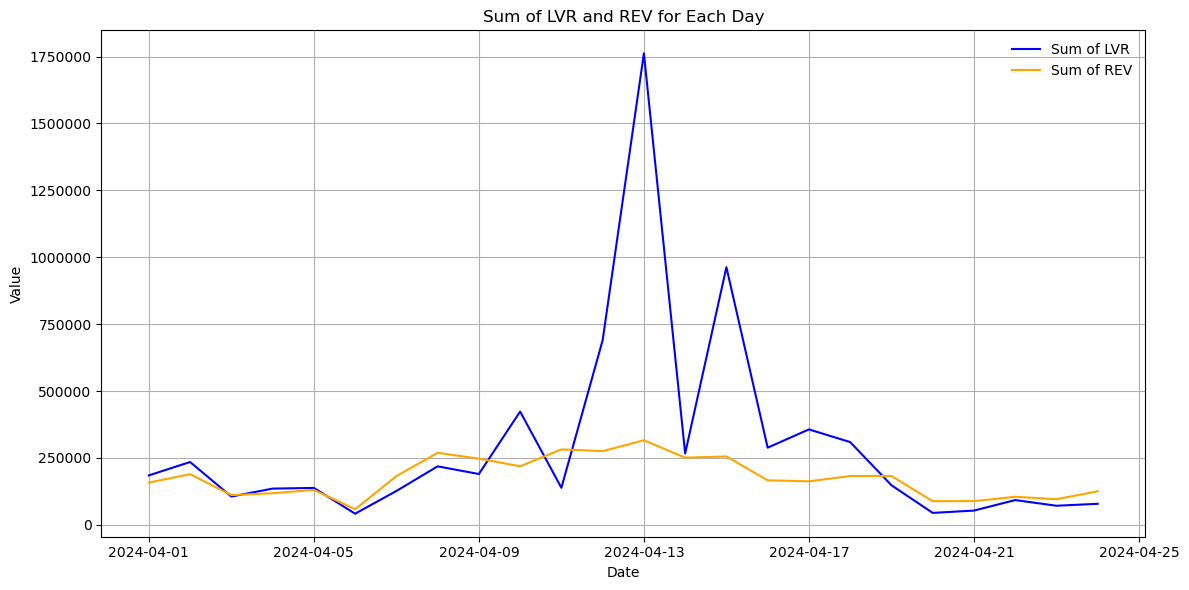

In [12]:
# Set figure size and background color
plt.figure(figsize=(12, 6), facecolor='white')
# Plot Sum of LVR
sns.lineplot(data=summary_data, x='datetime', y='sum_lvr', label='Sum of LVR', color='blue')
# Plot Sum of REV on the same axes
sns.lineplot(data=summary_data, x='datetime', y='sum_rev', label='Sum of REV', color='orange')
# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sum of LVR and REV for Each Day')
# Show legend
plt.legend(loc='best', frameon=False)
# Add grid
plt.grid(True)
# Ensure y-axis shows actual values
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
# Show the plot
plt.tight_layout()
plt.show()

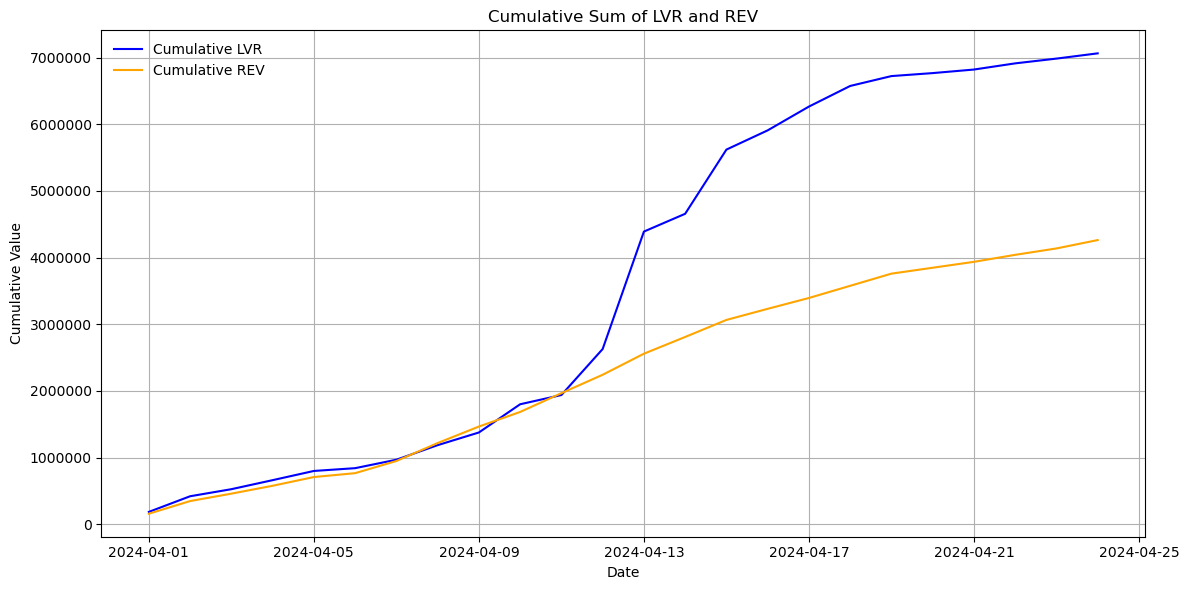

In [13]:
# Set figure size and background color
plt.figure(figsize=(12, 6), facecolor='white')
# Plot Cumulative LVR
sns.lineplot(data=summary_data, x='datetime', y='cumulative_lvr', label='Cumulative LVR', color='blue')
# Plot Cumulative REV
sns.lineplot(data=summary_data, x='datetime', y='cumulative_rev', label='Cumulative REV', color='orange')
# Set labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Sum of LVR and REV')
# Show legend
plt.legend(loc='best', frameon=False)
# Add grid
plt.grid(True)
# Ensure y-axis shows actual values
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
# Show the plot
plt.tight_layout()
plt.show()

Initially, in the graph, the Cumulative Loss-versus-Rebalancing (LVR) and the Cumulative Revenue (REV) from providing liquidity track closely together, indicating a relatively balanced relationship between the costs and income of providing liquidity.

However, around April 11, there is a marked change in the slope of the LVR curve, which becomes significantly steeper. This drastic change indicates that the opportunity costs associated with providing liquidity started to increase at a faster rate than before. Consequently, this implies that after this point, the losses incurred from rebalancing began to outweigh the revenue generated from liquidity fees at an accelerating rate.

The extreme change in the LVR slope suggests that external factors or market conditions may have influenced the costs of providing liquidity, emphasizing the need for liquidity providers to continuously monitor market dynamics and adjust their strategies accordingly.